# पीटर आणि लांडगा: वास्तववादी वातावरण

आपल्या परिस्थितीत, पीटर जवळजवळ थकलेला किंवा भुकेला न होता फिरू शकत होता. अधिक वास्तववादी जगात, त्याला वेळोवेळी बसून विश्रांती घ्यावी लागते आणि स्वतःला खायला लागते. खालील नियम लागू करून आपण आपले जग अधिक वास्तववादी बनवूया:

1. एका ठिकाणाहून दुसऱ्या ठिकाणी जाताना, पीटरची **ऊर्जा** कमी होते आणि त्याला **थकवा** येतो.
2. पीटर सफरचंद खाऊन अधिक ऊर्जा मिळवू शकतो.
3. पीटर झाडाखाली किंवा गवतावर विश्रांती घेऊन थकवा दूर करू शकतो (उदा. झाड किंवा गवत असलेल्या बोर्डच्या ठिकाणी चालत जाणे - हिरव्या रंगाचा भाग).
4. पीटरला लांडगा शोधून मारावा लागतो.
5. लांडग्याला मारण्यासाठी, पीटरकडे विशिष्ट पातळीची ऊर्जा आणि थकवा असणे आवश्यक आहे, अन्यथा तो लढाई हरतो.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

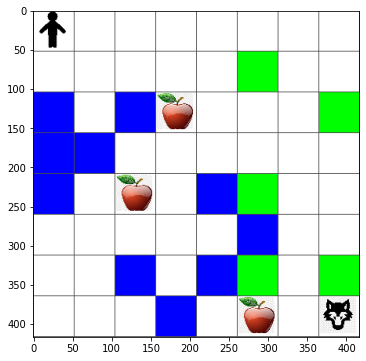

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## स्थिती परिभाषित करणे

आमच्या नवीन खेळाच्या नियमांमध्ये, प्रत्येक बोर्ड स्थितीवर ऊर्जा आणि थकवा याचा मागोवा ठेवणे आवश्यक आहे. त्यामुळे आम्ही `state` नावाचा एक ऑब्जेक्ट तयार करू जो सध्याच्या समस्येच्या स्थितीबद्दल सर्व आवश्यक माहिती ठेवेल, ज्यामध्ये बोर्डची स्थिती, ऊर्जा आणि थकव्याची सध्याची पातळी, आणि टर्मिनल स्थितीत असताना लांडग्याला जिंकता येईल का याचा समावेश असेल:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## बक्षीस फंक्शन

### ओळख
बक्षीस फंक्शन हे एजंटच्या वर्तनाचे मूल्यांकन करण्यासाठी वापरले जाते. हे एजंटला योग्य कृती करण्यासाठी प्रोत्साहन देते आणि चुकीच्या कृती टाळण्यासाठी दंड देते.

### महत्त्व
बक्षीस फंक्शन योग्य प्रकारे डिझाइन करणे अत्यंत महत्त्वाचे आहे कारण ते एजंटच्या शिकण्याच्या प्रक्रियेवर थेट परिणाम करते. चुकीचे बक्षीस फंक्शन एजंटला अयोग्य वर्तन शिकवू शकते.

### डिझाइन टिप्स
- **स्पष्टता:** बक्षीस फंक्शन स्पष्ट आणि सोपे असावे. जटिल बक्षीस प्रणाली एजंटसाठी गोंधळ निर्माण करू शकते.
- **सुसंगतता:** बक्षीस फंक्शन एजंटच्या उद्दिष्टांशी सुसंगत असावे.
- **तत्काळता:** बक्षीस त्वरित दिले जावे, जेणेकरून एजंटला त्याच्या कृतींचा परिणाम समजेल.

### उदाहरण
खाली दिलेले बक्षीस फंक्शन एजंटला लक्ष्य गाठण्यासाठी प्रोत्साहन देते:

```python
def reward_function(agent_position, target_position):
    distance = calculate_distance(agent_position, target_position)
    if distance == 0:
        return 100  # लक्ष्य गाठल्यावर मोठा बक्षीस
    else:
        return -distance  # लक्ष्यापासून अंतरावर आधारित दंड
```

### सामान्य चुका
- **अतिशय कठोर दंड:** कठोर दंड एजंटला गोंधळात टाकू शकतो आणि शिकण्याची प्रक्रिया मंद करू शकतो.
- **अतिशय उदार बक्षीस:** उदार बक्षीस एजंटला अयोग्य वर्तनासाठी प्रोत्साहन देऊ शकते.
- **अस्पष्ट उद्दिष्टे:** अस्पष्ट बक्षीस प्रणाली एजंटला योग्य वर्तन शिकण्यात अडथळा आणू शकते.

### निष्कर्ष
बक्षीस फंक्शन डिझाइन करताना काळजीपूर्वक विचार करणे आवश्यक आहे. योग्य बक्षीस प्रणाली एजंटला प्रभावीपणे शिकण्यास मदत करू शकते आणि त्याच्या उद्दिष्टांपर्यंत पोहोचण्याची शक्यता वाढवते.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learning अल्गोरिदम

खरं तर शिकण्याचा अल्गोरिदम फारसा बदलत नाही, आपण फक्त बोर्ड स्थितीऐवजी `state` वापरतो.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

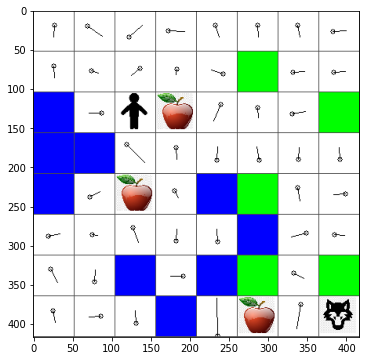

In [11]:
m.plot(Q)

## निकाल

पहा, आपण पीटरला लांडग्याशी लढण्यासाठी प्रशिक्षण देण्यात यशस्वी झालो का!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


आता आपल्याला बुडण्याच्या खूपच कमी घटना दिसतात, पण पीटर अजूनही नेहमी लांडग्याला मारू शकत नाही. हायपरपॅरामिटर्ससह प्रयोग करून पाहा आणि तुम्ही हा परिणाम सुधारू शकता का ते पाहा.


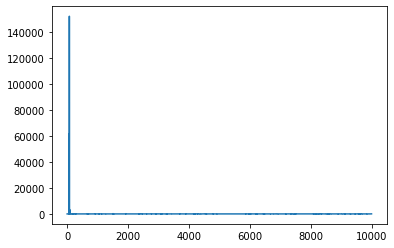

In [13]:
plt.plot(lpath)


---

**अस्वीकरण**:  
हा दस्तऐवज AI भाषांतर सेवा [Co-op Translator](https://github.com/Azure/co-op-translator) चा वापर करून भाषांतरित करण्यात आला आहे. आम्ही अचूकतेसाठी प्रयत्नशील असलो तरी कृपया लक्षात ठेवा की स्वयंचलित भाषांतरांमध्ये त्रुटी किंवा अचूकतेचा अभाव असू शकतो. मूळ भाषेतील दस्तऐवज हा अधिकृत स्रोत मानला जावा. महत्त्वाच्या माहितीसाठी व्यावसायिक मानवी भाषांतराची शिफारस केली जाते. या भाषांतराचा वापर करून उद्भवलेल्या कोणत्याही गैरसमज किंवा चुकीच्या अर्थासाठी आम्ही जबाबदार राहणार नाही.
